## Lab 11: Long Short Term Memory (LSTM) Models
#### Pranisaa Charnparttaravanit
#### st121720


The task for this lab is to find a dataset and evaluate it with the code developed in class. The chosen data set is called MultiWOZ_2.2 taken from th elinke attached below.

### 1. Get data set

#### 1.1 Get data provided by Github 
Link https://raw.githubusercontent.com/budzianowski/multiwoz/master/data/MultiWOZ_2.2/

In [28]:
for i in ['001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016','017']:
    !wget 'https://raw.githubusercontent.com/budzianowski/multiwoz/master/data/MultiWOZ_2.2/train/dialogues_{i}.json'
    !mv 'dialogues_{i}.json' 'data/multiwoz/'

--2021-04-08 13:44:29--  https://raw.githubusercontent.com/budzianowski/multiwoz/master/data/MultiWOZ_2.2/train/dialogues_001.json
Connecting to 192.41.170.23:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10678768 (10M) [text/plain]
Saving to: ‘dialogues_001.json’

dialogues_001.json  100%[===================>]  10.18M  7.99MB/s    in 1.3s    

2021-04-08 13:44:31 (7.99 MB/s) - ‘dialogues_001.json’ saved [10678768/10678768]

--2021-04-08 13:44:32--  https://raw.githubusercontent.com/budzianowski/multiwoz/master/data/MultiWOZ_2.2/train/dialogues_002.json
Connecting to 192.41.170.23:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10779713 (10M) [text/plain]
Saving to: ‘dialogues_002.json’

dialogues_002.json  100%[===================>]  10.28M  9.50MB/s    in 1.1s    

2021-04-08 13:44:33 (9.50 MB/s) - ‘dialogues_002.json’ saved [10779713/10779713]

--2021-04-08 13:44:35--  https://raw.githubusercontent.com/budzianowski/multiwoz/mas

In [1]:
import json
import pandas as pd
  
for i in ['001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016','017']:
    if i =='001':
        f = open(f'data/multiwoz/dialogues_{i}.json')
        data = json.load(f)
        all_question, all_answer = [], []

        for qa in data:
            all_question.append(qa[u'turns'][0][u'utterance'])
            all_answer.append(qa[u'turns'][1][u'utterance'])

        all_0 = pd.DataFrame([all_question,all_answer]).T

    else : 
        f = open(f'data/multiwoz/dialogues_{i}.json')
        data = json.load(f)
        all_question, all_answer = [], []

        for qa in data:
            all_question.append(qa[u'turns'][0][u'utterance'])
            all_answer.append(qa[u'turns'][1][u'utterance'])

        all_1 = pd.DataFrame([all_question,all_answer]).T

        all = pd.concat([all_0, all_1], axis=0)

In [2]:
all

,0,1
0,i need a place to dine in the center thats exp...,I have several options for you; do you prefer ...
1,"Guten Tag, I am staying overnight in Cambridge...",I have 4 different options for you. I have two...
2,Hi there! Can you give me some info on Cityroomz?,"Cityroomz is located at Sleeperz Hotel, Statio..."
3,I am looking for a hotel named alyesbray lodge...,"i have their info, what would you like to know?"
4,i need a train on tuesday out of kings lynn,What time of day would you like to leave?
...,...,...
241,I would like to visit some of the architecture...,I can indeed. We have several churches and a s...
242,"Hi, can you help me find a moderately priced 3...",I have 4 guesthouses with 3 stars that are mod...
243,Hi! I am looking for a train that arrives by 1...,I have 122 trains that are arriving by 11:30. ...
244,I would like the phone number of an expensive ...,There are five restaurants in the expensive pr...


#### 1.2 Save as txt file

In [6]:
import numpy as np

np.savetxt(r'data/qa/multiwoz_all.txt', all_.values, fmt='%s', delimiter='\t')

### 2. Define Model

In [7]:
import torch
from torch import nn

class NaiveCustomLSTM(nn.Module):
    
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        
        # Parameters for computing i_t
        self.U_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))
        
        # Parameters for computing f_t
        self.U_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))
        
        # Parameters for computing c_t
        self.U_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))
        
        # Parameters for computing o_t
        self.U_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))
        
        self.init_weights()
                
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
         
    def forward(self, x, init_states=None):
        """
        forward: Run input x through the cell. Assumes x.shape is (batch_size, sequence_length, input_size)
        """
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        
        if init_states is None:
            h_t, c_t = (
                torch.zeros(bs, self.hidden_size).to(x.device),
                torch.zeros(bs, self.hidden_size).to(x.device),
            )
        else:
            h_t, c_t = init_states
            
        for t in range(seq_sz):
            x_t = x[:, t, :]
            
            i_t = torch.sigmoid(x_t @ self.U_i + h_t @ self.V_i + self.b_i)
            f_t = torch.sigmoid(x_t @ self.U_f + h_t @ self.V_f + self.b_f)
            g_t = torch.tanh(x_t @ self.U_c + h_t @ self.V_c + self.b_c)
            o_t = torch.sigmoid(x_t @ self.U_o + h_t @ self.V_o + self.b_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            
            hidden_seq.append(h_t.unsqueeze(0))
        
        # Reshape hidden_seq tensor to (batch size, sequence length, hidden_size)
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        return hidden_seq, (h_t, c_t)

#### Check availability of GPU

In [8]:
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import pickle
from torch.autograd import Variable

from chosen_gpu import get_freer_gpu
device = torch.device(get_freer_gpu()) 
print("Configured device: ", device)

Configured device:  cuda:2


### 3. Load and preprocess the data

In [52]:
# Reserved word tokens

PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:

    def __init__(self):        
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index: # add new index for new word
            self.word2index[word] = self.num_words
            self.word2count[word] = 1 # set count
            self.index2word[self.num_words] = word
            self.num_words += 1 #update uniqiue word
        else:
            self.word2count[word] += 1 # count

    # Remove words below a certain count threshold

    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries

        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [53]:
MAX_LENGTH = 30  # Maximum sentence length to consider

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a Voc object

def readVocs(datafile):
    print("Reading lines...")    
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc()
    return voc, pairs

# Boolean function returning True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold

def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using the filterPair predicate

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list

def loadPrepareData(datafile):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs

In [57]:
datafile = 'data/qa/multiwoz_all.txt'
voc, pairs = loadPrepareData(datafile)

# Print some pairs to validate

print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 8437 sentence pairs
Trimmed to 7913 sentence pairs
Counting words...
Counted words: 2439

pairs:
['i need a place to dine in the center thats expensive', 'i have several options for you do you prefer african asian or british food ?']
['guten tag i am staying overnight in cambridge and need a place to sleep . i need free parking and internet .', 'i have different options for you . i have two cheaper guesthouses and two expensive hotels . do you have a preference ?']
['i am looking for a hotel named alyesbray lodge guest house .', 'i have their info what would you like to know ?']
['i need a train on tuesday out of kings lynn', 'what time of day would you like to leave ?']
['i am looking for a restaurant . i would like something cheap that has chinese food .', 'i ve heard good things about the lucky star . need a reservation ?']
['please find me a train from cambridge to stansted airport', 'sure i can do that but first i need a litt

In [58]:

MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs

# Trim vocabulary and pairs

pairs_ = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 1393 / 2436 = 0.5718
Trimmed from 7913 pairs to 6903, 0.8724 of total


### 4. Split dataset into testing and training pair sets

Let's split the dataset into the first 45,000 pairs for training and the rest for testing:

In [59]:
print(len(pairs))
testpairs = pairs_[6000:]
pairs  = pairs_[:6000]

7913


In [60]:
print(len(pairs_))


6903


### 5. Convert pairs to tensors


In [61]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]

def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Return a padded input sequence tensor and the lengths of each original sequence

def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Return a padded target sequence tensor, a padding mask, and the max target length

def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Return all items for a given batch of pairs

def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len

# Example for validation

small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

As LSTM takes time series data so we need to convert our pairs of sentences into time series.

In [62]:
pair_batch = pairs[:5]
print(pair_batch)
pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
print('='*20)
print(pair_batch)
print('='*20)
print(target_variable)
print('='*20)
print(mask)
print('='*20)
print(max_target_len)

[['i need a place to dine in the center thats expensive', 'i have several options for you do you prefer african asian or british food ?'], ['i need a train on tuesday out of kings lynn', 'what time of day would you like to leave ?'], ['i am looking for a restaurant . i would like something cheap that has chinese food .', 'i ve heard good things about the lucky star . need a reservation ?'], ['please find me a train from cambridge to stansted airport', 'sure i can do that but first i need a little more information . what day would you like to travel as well as departure and arrival times ?'], ['i m looking for an expensive restaurant in the centre if you could help me .', 'i sure can . there are lots of choices . are you looking for a particular type of food ?']]
[['i am looking for a restaurant . i would like something cheap that has chinese food .', 'i ve heard good things about the lucky star . need a reservation ?'], ['i m looking for an expensive restaurant in the centre if you cou

### 6. Define models

#### 6.1 Encoder

In [63]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.gru = nn.LSTM(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        
        embedded = self.embedding(input_seq)

        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths.cpu())
        
        outputs, hidden = self.gru(packed, hidden)
        
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        
        return outputs, hidden
    def init_hidden(self):
        
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

#### 6.2 Decoder


In [65]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

       
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))#, bidirectional=True)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, input_step, last_hidden, encoder_outputs):
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        rnn_output, hidden = self.gru(embedded, last_hidden)
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        return output, hidden

##### 6.2.1 Attention weights

In [64]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        
    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def forward(self, hidden, encoder_outputs):
        
        attn_energies = self.dot_score(hidden, encoder_outputs)
        attn_energies = attn_energies.t()
        return F.softmax(attn_energies, dim=1).unsqueeze(1)   

### 8. Training procedure

In [66]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

#### 8.1 Train function

In [67]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

  
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    
    loss = 0
    print_losses = []
    n_totals = 0

    
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    
    decoder_hidden = encoder_hidden[:decoder.n_layers]
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            
            decoder_input = target_variable[t].view(1, -1)
            
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    
    loss.backward()

    
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

#### 8.3 Full training procedure

In [68]:
 max_target_len 

29

In [69]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    losslist = []
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0
            losslist.append(print_loss_avg)
        
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            print(directory)
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'check:qpoint')))
    return losslist

### 9. Evaluation function
#### 9.1 **Greedy decoding**


In [70]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
       
        for _ in range(max_length):
            
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            
            decoder_input = torch.unsqueeze(decoder_input, 0)
        
        return all_tokens, all_scores

#### 9.1.2 Evaluating some text


In [71]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
  
    indexes_batch = [indexesFromSentence(voc, sentence)]
    
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    
    tokens, scores = searcher(input_batch, lengths, max_length)
    
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            
            input_sentence = input('> ')
            
            if input_sentence == 'q' or input_sentence == 'quit': break
            
            input_sentence = normalizeString(input_sentence)
            
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

#### 9.1.3 Run Model

In [39]:
model_name = 'cb_model'
attn_model = 'dot'

hidden_size = 512
encoder_n_layers = 2
decoder_n_layers = 4
dropout = 0.5
batch_size = 256 
loadFilename = None

embedding = nn.Embedding(voc.num_words, hidden_size)
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
encoder = encoder.to(device)
decoder = decoder.to(device)

In [40]:
save_dir = 'content/'
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 10000
print_every = 250
save_every = 100
loadFilename = None
corpus_name="Chat"
encoder.train()
decoder.train()
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
print("Starting Training!")
lossvalues = trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Starting Training!
Initializing ...
Training...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  after removing the cwd from sys.path.


content/cb_model/Chat/2-4_512
content/cb_model/Chat/2-4_512
Iteration: 250; Percent complete: 2.5%; Average loss: 4.5527
content/cb_model/Chat/2-4_512
content/cb_model/Chat/2-4_512
Iteration: 500; Percent complete: 5.0%; Average loss: 3.1545
content/cb_model/Chat/2-4_512
content/cb_model/Chat/2-4_512
content/cb_model/Chat/2-4_512
Iteration: 750; Percent complete: 7.5%; Average loss: 2.3426
content/cb_model/Chat/2-4_512
content/cb_model/Chat/2-4_512
Iteration: 1000; Percent complete: 10.0%; Average loss: 1.9632
content/cb_model/Chat/2-4_512
content/cb_model/Chat/2-4_512
content/cb_model/Chat/2-4_512
Iteration: 1250; Percent complete: 12.5%; Average loss: 1.7084
content/cb_model/Chat/2-4_512
content/cb_model/Chat/2-4_512
Iteration: 1500; Percent complete: 15.0%; Average loss: 1.4828
content/cb_model/Chat/2-4_512
content/cb_model/Chat/2-4_512
content/cb_model/Chat/2-4_512
Iteration: 1750; Percent complete: 17.5%; Average loss: 1.2811
content/cb_model/Chat/2-4_512
content/cb_model/Chat/2-4

#### 9.1.4 Plot graph

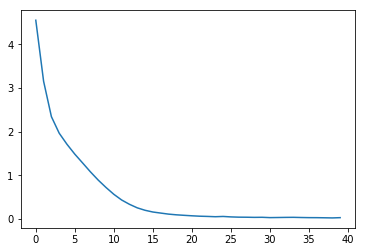

In [42]:
import matplotlib.pyplot as plt
plt.plot(lossvalues)
plt.show()

#### 9.1.5 Bleu score Calculation

In [43]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction


searcher = GreedySearchDecoder(encoder, decoder)
gram1_bleu_score = []
gram2_bleu_score = []
# print(len(testpairs))
for i in range(0,len(testpairs),1):
    input_sentence = testpairs[i][0]
  
    reference = testpairs[i][1:]
    templist = []
    for k in range(len(reference)):
        if(reference[k]!=''):
            temp = reference[k].split(' ')
            templist.append(temp)
  
  
    input_sentence = normalizeString(input_sentence)
    output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
    output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
    chencherry = SmoothingFunction()
#   print(output_words)
#   print(templist)
    score1 = sentence_bleu(templist,output_words,weights=(1, 0, 0, 0) ,smoothing_function=chencherry.method1)
    score2 = sentence_bleu(templist,output_words,weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method1) 
    gram1_bleu_score.append(score1)
    gram2_bleu_score.append(score2)
    if i%1000 == 0:
        print(i,sum(gram1_bleu_score)/len(gram1_bleu_score),sum(gram2_bleu_score)/len(gram2_bleu_score))
print("Total Bleu Score for 1 grams on testing pairs: ", sum(gram1_bleu_score)/len(gram1_bleu_score) )  
print("Total Bleu Score for 2 grams on testing pairs: ", sum(gram2_bleu_score)/len(gram2_bleu_score) )

0 0.2857142857142857 0.032530002431617765
Total Bleu Score for 1 grams on testing pairs:  0.25196698706007564
Total Bleu Score for 2 grams on testing pairs:  0.13918339745773478


In [44]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)
# input
# Hi, how are you?
# What
# I don't understand you
# hmm, good bye

>  hi


Bot: do you want to start in a particular area ? also also need them . is cheap .


>  how much?


Bot: i have no results for entertainments . would you like to find it down ? is there a certain part of town you d like to find ?


>  which city?


Bot: what type of food would you like ? are you interested in a certain area ? is an certain number . are also an king number .


>  pizza


Bot: what type of food would you like ? is available . is in the centre . has free parking . . has free


KeyboardInterrupt: Interrupted by user

#### 9.2 Beam Decoder


In [72]:
class Sentence:
    def __init__(self, decoder_hidden, last_idx=SOS_token, sentence_idxes=[], sentence_scores=[]):
        if(len(sentence_idxes) != len(sentence_scores)):
            raise ValueError("length of indexes and scores should be the same")
        self.decoder_hidden = decoder_hidden
        self.last_idx = last_idx
        self.sentence_idxes =  sentence_idxes
        self.sentence_scores = sentence_scores

    def avgScore(self):
        if len(self.sentence_scores) == 0:
            raise ValueError("Calculate average score of sentence, but got no word")
        # return mean of sentence_score
        return sum(self.sentence_scores) / len(self.sentence_scores)

    def addTopk(self, topi, topv, decoder_hidden, beam_size, voc):
        topv = torch.log(topv)
        terminates, sentences = [], []
        for i in range(beam_size):
            if topi[0][i] == EOS_token:
                terminates.append(([voc.index2word[idx.item()] for idx in self.sentence_idxes] + ['<EOS>'],
                                   self.avgScore())) 
                continue
            idxes = self.sentence_idxes[:] 
            scores = self.sentence_scores[:] 
            idxes.append(topi[0][i])
            scores.append(topv[0][i])
            sentences.append(Sentence(decoder_hidden, topi[0][i], idxes, scores))
        return terminates, sentences

    def toWordScore(self, voc):
        
        words = []
        for i in range(len(self.sentence_idxes)):
            if self.sentence_idxes[i] == EOS_token:
                words.append('<EOS>')
            else:
                words.append(voc.index2word[self.sentence_idxes[i].item()])
       
        if self.sentence_idxes[-1] != EOS_token:
            words.append('<EOS>')
        return (words, self.avgScore())

    def __repr__(self):
        res = f"Sentence with indices {self.sentence_idxes} "
        res += f"and scores {self.sentence_scores}"
        return res
def beam_decode(decoder, decoder_hidden, encoder_outputs, voc, beam_size, max_length=MAX_LENGTH):
    terminal_sentences, prev_top_sentences, next_top_sentences = [], [], []
    prev_top_sentences.append(Sentence(decoder_hidden))
    for i in range(max_length):
        
        for sentence in prev_top_sentences:
            decoder_input = torch.LongTensor([[sentence.last_idx]])
            decoder_input = decoder_input.to(device)

            decoder_hidden = sentence.decoder_hidden
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(beam_size)
            term, top = sentence.addTopk(topi, topv, decoder_hidden, beam_size, voc)
            terminal_sentences.extend(term)
            next_top_sentences.extend(top)
           
        
        next_top_sentences.sort(key=lambda s: s.avgScore(), reverse=True)
        prev_top_sentences = next_top_sentences[:beam_size]
        next_top_sentences = []
        

    terminal_sentences += [sentence.toWordScore(voc) for sentence in prev_top_sentences]
    terminal_sentences.sort(key=lambda x: x[1], reverse=True)

    n = min(len(terminal_sentences), 15)
    return terminal_sentences[:n]



class BeamSearchDecoder(nn.Module):

    def __init__(self, encoder, decoder, voc, beam_size=10):
        super(BeamSearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.voc = voc
        self.beam_size = beam_size

    def forward(self, input_seq, input_length, max_length):
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        
        decoder_hidden = encoder_hidden[:self.decoder.n_layers]
        
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        sentences = beam_decode(self.decoder, decoder_hidden, encoder_outputs, self.voc, self.beam_size, max_length)
        
        
        all_tokens = [torch.tensor(self.voc.word2index.get(w, 0)) for w in sentences[0][0]]
        return all_tokens, None

    def __str__(self):
        res = f"BeamSearchDecoder with beam size {self.beam_size}"
        return res


#### 9.2.1 Run model

In [73]:
model_name = 'cb_model'
attn_model = 'dot'

hidden_size = 512
encoder_n_layers = 2
decoder_n_layers = 4
dropout = 0.5
batch_size = 256 
loadFilename = None

embedding = nn.Embedding(voc.num_words, hidden_size)
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
encoder = encoder.to(device)
decoder = decoder.to(device)

In [74]:
save_dir = 'content/'
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 6000
print_every = 250
save_every = 2000
loadFilename = None
corpus_name="Chat"
encoder.train()
decoder.train()
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
print("Starting Training!")
lossvalues = trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Starting Training!
Initializing ...
Training...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  after removing the cwd from sys.path.


Iteration: 250; Percent complete: 4.2%; Average loss: 4.5309
Iteration: 500; Percent complete: 8.3%; Average loss: 3.1358
Iteration: 750; Percent complete: 12.5%; Average loss: 2.3069
Iteration: 1000; Percent complete: 16.7%; Average loss: 1.9182
Iteration: 1250; Percent complete: 20.8%; Average loss: 1.6442
Iteration: 1500; Percent complete: 25.0%; Average loss: 1.4022
Iteration: 1750; Percent complete: 29.2%; Average loss: 1.1859
Iteration: 2000; Percent complete: 33.3%; Average loss: 0.9709
content/cb_model/Chat/2-4_512
Iteration: 2250; Percent complete: 37.5%; Average loss: 0.7857
Iteration: 2500; Percent complete: 41.7%; Average loss: 0.6115
Iteration: 2750; Percent complete: 45.8%; Average loss: 0.4670
Iteration: 3000; Percent complete: 50.0%; Average loss: 0.3549
Iteration: 3250; Percent complete: 54.2%; Average loss: 0.2696
Iteration: 3500; Percent complete: 58.3%; Average loss: 0.2100
Iteration: 3750; Percent complete: 62.5%; Average loss: 0.1636
Iteration: 4000; Percent compl

#### 9.2.2 Plot

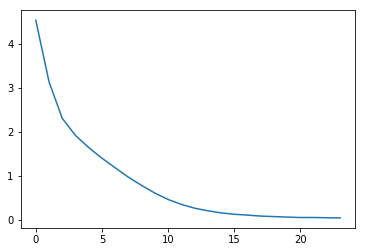

In [75]:
import matplotlib.pyplot as plt

plt.plot(lossvalues)
plt.show()

#### 9.2.3 Bleu score Calculation

In [76]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

############################################################################
# Difference between greedy search and beam search is here

# greedy search
# searcher = GreedySearchDecoder(encoder, decoder)

# beam search
searcher = BeamSearchDecoder(encoder, decoder, voc, 10)
############################################################################
gram1_bleu_score = []
gram2_bleu_score = []

for i in range(0,len(testpairs),1):
#     print('im here')
    input_sentence = testpairs[i][0]

    reference = testpairs[i][1:]
    templist = []
    for k in range(len(reference)):
#         print('im here2')
        if(reference[k]!=''):
#             print('im here3')
            temp = reference[k].split(' ')
            templist.append(temp)


        input_sentence = normalizeString(input_sentence)
        output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
        output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
        chencherry = SmoothingFunction()
        score1 = sentence_bleu(templist,output_words,weights=(1, 0, 0, 0) ,smoothing_function=chencherry.method1)
        score2 = sentence_bleu(templist,output_words,weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method1) 
#         print(score1)
#         print(score2)
        gram1_bleu_score.append(score1)
        gram2_bleu_score.append(score2)
        if i%1000 == 0:
            print(i,sum(gram1_bleu_score)/len(gram1_bleu_score),sum(gram2_bleu_score)/len(gram2_bleu_score))
print("Total Bleu Score for 1 grams on testing pairs: ", sum(gram1_bleu_score)/len(gram1_bleu_score))  
print("Total Bleu Score for 2 grams on testing pairs: ", sum(gram2_bleu_score)/len(gram2_bleu_score))  
# print(gram1_bleu_score)

0 0.2777777777777778 0.040422604172722164
Total Bleu Score for 1 grams on testing pairs:  0.30077562775304495
Total Bleu Score for 2 grams on testing pairs:  0.1783754233334607


#### 9.2.4. Chatting with BOT / Evaluation

In [77]:
encoder.eval()
decoder.eval()
searcher = BeamSearchDecoder(encoder, decoder, voc, 10)
evaluateInput(encoder, decoder, searcher, voc)

>  restuarant


Bot: there is a lot . what is your price range ?


>  300


Error: Encountered unknown word.


>  not expensive


Bot: is there a certain area you re looking for ?


>  downtown


Bot: is there a certain part of town you re looking for ?


>  at the center


Bot: i have a few . what would you like to know ?


KeyboardInterrupt: Interrupted by user

### What i learnt

I learnt the two different search algorithms adopted in the decoder namely Greedy and Beam search. Greedy search defines word with maximum provavility at every step. This method does not ensure optimal solution. On the other hand Beam search adds k candidate to the greedy search.

